In [1]:
import sys
sys.path.append('../libs/')
sys.path.append('../')
import morphen as mp
import libs as mlibs
import numpy as np
# from libs import *
import matplotlib.pyplot as plt
import os
import re
import glob
import tqdm
import lmfit
import scipy


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
   Radio Morphen              |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

## Spectral index maps
This implementation uses a robust fit, using the `LMFIT` package, to fit the spectral index of the source. The spectral index is defined as $\alpha = -\beta - 1$, where $\beta$ is the spectral index of the flux density, $S_\nu \propto \nu^\alpha$. For this initial experiment, we assume a linear slope in log scale. 

The spectral index is computed on `wsclean` sub-band images or multi-band `MFS` images.

In [57]:
root_path = '/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/'
prefix_images = "*multiscale..2.0*-????-image.fits"



HI, I need help to construct a script to calculate  spectral index  maps from radio images. 

Lets go 

In [58]:
imagelist = mlibs.glob.glob(root_path+prefix_images)
MFS_image = mlibs.glob.glob(root_path+'*multiscale..2.0*-MFS-image.fits')
MFS_residual = mlibs.glob.glob(root_path+'*multiscale..2.0*-MFS-residual.fits')

In [59]:
imagelist = glob.glob(root_path+prefix_images)
imagelist.sort(key=os.path.getmtime, reverse=False)

In [8]:
imagelist

['/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/final_image_MCG12-02-001.calibrated.avg12s_trial_1_2048x2048_0.06asec_100000.briggs.multiscale..2.0-0000-image.fits',
 '/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/final_image_MCG12-02-001.calibrated.avg12s_trial_1_2048x2048_0.06asec_100000.briggs.multiscale..2.0-0001-image.fits',
 '/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/final_image_MCG12-02-001.calibrated.avg12s_trial_1_2048x2048_0.06asec_100000.briggs.multiscale..2.0-0002-image.fits',
 '/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/final_image_MCG12-02-001.calibrated.avg12s_trial_1_2048x2048_0.06asec_100000.briggs.multiscale..2.0-0003-image.fits',
 '/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/final_image_MCG12-02-001.calibrated.avg12s_trial_1_2048x2048_0.06asec_100000.briggs.multiscale..2.0-0004-image.fi

In [9]:
def makecube(imagelist):
    temp = []
    for image in imagelist:
        temp.append(mlibs.ctn(image))
    return np.dstack(temp)

from astropy.io import fits
from astropy.wcs import WCS

def getfreqs(fitslist):
    freqs = []
    for fitsfile in fitslist:
        hdu = fits.open(fitsfile)
        hdr = hdu[0].header
        freq = hdr['CRVAL3']
        freqs.append(freq)
    freqs = np.array(freqs)
    return freqs

In [26]:
import lmfit
def linear_function(x, a, b):
    return a + b*x #+ c*x*x
def do_fit_spec(data,freqs):
    def linear_function(x, a, b):
        return a + b*x #+ c*x*x
    
    def min_func(params):
        a = params['a']
        b = params['b']
        res = data - linear_function(freqs, a, b)
        return res.copy()
        
    
    fit_params = lmfit.Parameters()
    fit_params.add("a", value=0.0, min=-100, max=100)
    fit_params.add("b", value=-1.0, min=-2.5, max=1.5)
    
    mini = lmfit.Minimizer(min_func, fit_params, max_nfev=5000,
                        nan_policy='omit', reduce_fcn='neglogcauchy')
    
    result_1 = mini.minimize(method='least_squares',
                           max_nfev=200000, #f_scale = 1.0,
                           loss="cauchy", tr_solver="exact",
                           ftol=1e-12, xtol=1e-12, gtol=1e-12, 
                           verbose=0
                           )
    second_run_params = result_1.params
    
    result = mini.minimize(method='least_squares',
                           params=second_run_params,
                           max_nfev=200000, #f_scale = 1.0,
                           loss="cauchy", tr_solver="exact",
                           ftol=1e-12, xtol=1e-12, gtol=1e-12, 
                           verbose=0
                        )
    
    return result

In [31]:
def specidx_map(imagelist,
                ref_image_mask = None,
                mask=None,sigma_global_mask=12):
    cube_image = makecube(imagelist)
    
    if mask is None:
        if ref_image_mask is not None:
            ref_image_mask = ref_image_mask
        else:
            ref_image_mask = imagelist[0]
        _,mask = mlibs.mask_dilation(ref_image_mask,
                                     show_figure=True,
                                     PLOT=True,
                                     sigma=sigma_global_mask)
    mask_3d = mask[:, :, np.newaxis]
    inv_mask = ~mask
    inv_mask_3d = inv_mask[:, :, np.newaxis]
    
    psf_beam_zise = int(mlibs.get_beam_size_px(imagelist[0])[0])
    psf_size = int(mlibs.ctn(imagelist[0]).shape[0])
    print(f"PSF BEAM SIZE is --> {psf_beam_zise} px")
    print(f"PSF IMAGE SIZE is --> {psf_size} px")

    psf_name = mlibs.tcreate_beam_psf(imagelist[0],
                                    size=(psf_size, psf_size),
                                    aspect = 'elliptical')
    PSF_BEAM = mlibs.ctn(psf_name)
    
    num_images = cube_image.shape[2]
    conv_cube = np.empty_like(cube_image)
    for i in tqdm.tqdm(range(num_images)):
        conv_cube[:, :, i] = scipy.signal.fftconvolve(cube_image[:, :, i], 
                                                      PSF_BEAM, 'same')
        conv_image_i = conv_cube[:, :, i]
        conv_name = imagelist[i].replace('image.fits','image-conv.fits')
        mlibs.pf.writeto(conv_name,
                         conv_image_i,
                         overwrite=True)
        mlibs.copy_header(imagelist[i],conv_name,conv_name)
        
    
    masked_cube = np.where(inv_mask_3d, np.nan, conv_cube)
    # cube_image * mask_3d
    idx = np.column_stack(np.where(mask==True))
    freqs = getfreqs(imagelist)
    alphaimage = np.empty_like(conv_cube[:,:,0])
    alphaimage_error = np.empty_like(conv_cube[:,:,0])
    
    alphaimage[:] = np.nan
    alphaimage_error[:] = np.nan
    
    x = np.log10(freqs)
    
    nspec = len(idx)
    tenpc = int(nspec / 10.0)
    count = 0
    pcount = 0
    
    for i, j in tqdm.tqdm(idx):
        # if count == 0:
        #     print(str(pcount) + '%...')
        
        y = np.log10(masked_cube[i,j,:])
        results_fit = do_fit_spec(y,x)
        
        alphaimage[i, j] = results_fit.params['b'].value
        alphaimage_error[i, j] = results_fit.params['b'].stderr
        count += 1
        if count == tenpc:
            count = 0
            pcount += 10
    
    _,mask_lower = mlibs.mask_dilation(imagelist[0],
                                       show_figure=True,
                                       PLOT=True,
                                       sigma=6)
    
    
    alphaimage_name = imagelist[0].replace('-0000-image.fits','-alpha.fits')
    alphaimage_error_name = imagelist[0].replace('-0000-image.fits','-alphaerror.fits')
    mlibs.pf.writeto(alphaimage_name,alphaimage,overwrite=True)
    mlibs.pf.writeto(alphaimage_error_name,alphaimage_error,overwrite=True)
    mlibs.copy_header(imagelist[0],alphaimage_name,alphaimage_name)
    mlibs.copy_header(imagelist[0],alphaimage_error_name,alphaimage_error_name)
    
    return(alphaimage, alphaimage_error)
        
        
    
    

 ==>  Dilation size is 6 [px]


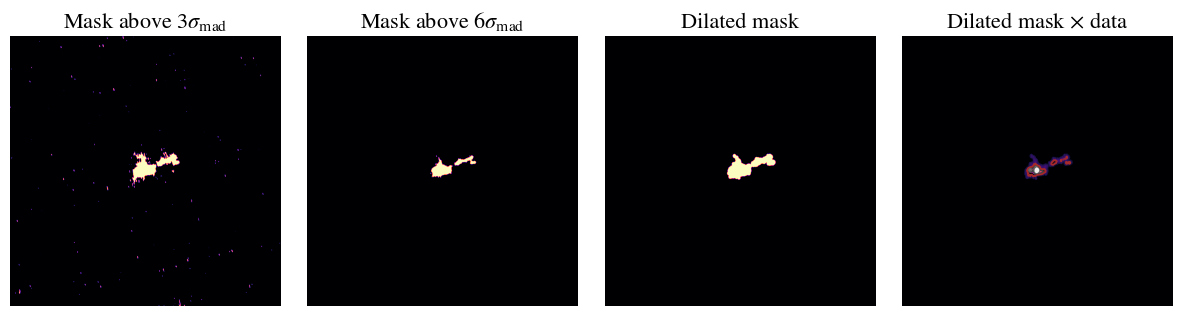

PSF BEAM SIZE is --> 13 px
PSF IMAGE SIZE is --> 2048 px
INFO: Using Elliptical Gaussian for Gaussian beam convolution.
++==>>  PSF major/minor axis = ', 0.7973092094453784arcsec X 0.7973092094453784arcsec


2024-01-29 03:46:12	WARN	componentlist::close	componentlist closed
  5%|▌         | 1633/32208 [00:06<02:00, 252.74it/s]/tmp/ipykernel_1499899/3759022191.py:63: RuntimeWarning: invalid value encountered in log10
  y = np.log10(masked_cube[i,j,:])
100%|██████████| 32208/32208 [02:05<00:00, 256.87it/s]


 ==>  Dilation size is 6 [px]


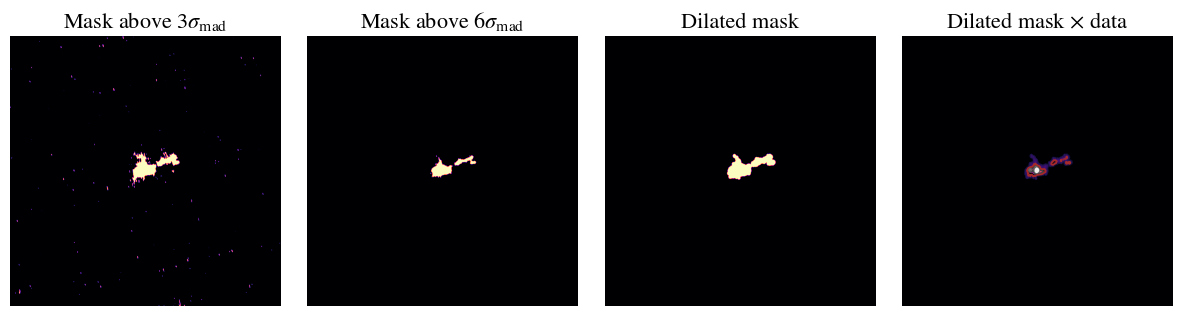

In [33]:
alphaimage, alphaimage_error = specidx_map(imagelist,
                                        #    ref_image_mask = MFS_image[0],
                                           mask=None,
                                           sigma_global_mask=6
                                           )

/tmp/ipykernel_1499899/3406404137.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(alphaimage,axis=0),'.')
/tmp/ipykernel_1499899/3406404137.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(alphaimage_error,axis=0),'.')


(-2.0, 1.0)

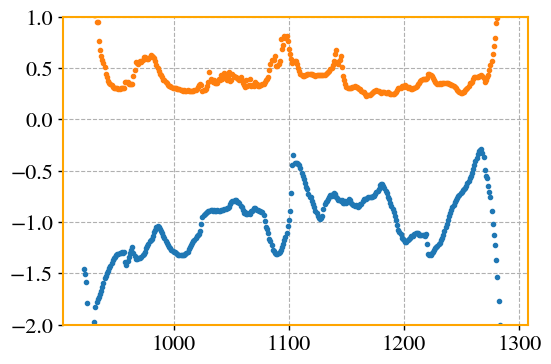

In [38]:
plt.plot(np.nanmean(alphaimage,axis=0),'.')
plt.plot(np.nanmean(alphaimage_error,axis=0),'.')
plt.ylim(-2.0,1.)

In [46]:
MFS_image[0]

'/media/sagauga/starbyte/LIRGI_Sample_done/VLA-Archive/A_config/for_spidx/MCG12_C/final_image_MCG12-02-001.calibrated.avg12s_trial_1_2048x2048_0.06asec_100000.briggs.multiscale..2.0-MFS-image.fits'

In [56]:
center = mlibs.nd.maximum_position(mlibs.ctn(MFS_image[0]))


In [53]:
rr, ir = mlibs.get_profile(imagename=alphaimage,center=center)

Text(0, 0.5, 'Spectral Index')

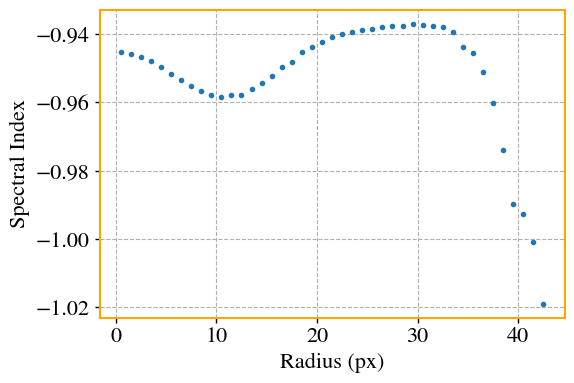

In [55]:
plt.plot(rr,ir,'.')
plt.xlabel('Radius (px)')
plt.ylabel('Spectral Index')